In [19]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0.,5.], [10.,-5.]]
target = mm.multipleCircles(origin_target, radius, nb_pts)

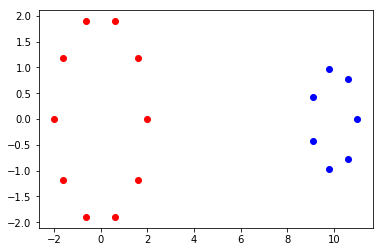

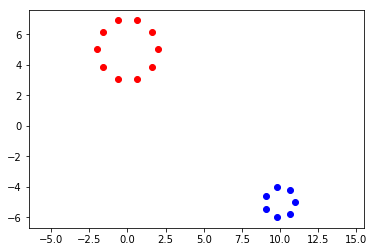

In [21]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [15]:
# Defining the deformation modules
sigma1 = 3
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1)
mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 3
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2)
mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [16]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [17]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat([source[0], source[1], source[0], source[1]],0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [18]:
#gd0_list = [*source, source]
#mom0_list = [*[torch.zeros(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.zeros(gd.shape) for gd in modules.manifold.gd[-1]]]

In [ ]:
#H.module.manifold.fill_gd([gd0_list[0].view(-1), gd0_list[1].view(-1), [gd0_list[2][0].view(-1), gd0_list[2][1].view(-1)]])
#H.module.manifold.fill_cotan([mom0_list[0].view(-1), mom0_list[1].view(-1), [mom0_list[2][0].view(-1), mom0_list[2][1].view(-1)]])
#H.geodesic_controls()

In [ ]:
# set parameters
reg_param = 10**-2 # regularisation parameter

#gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_().view(-1)
#mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_().view(-1)
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

In [ ]:
EnergyFunctional.modules.compute_geodesic_variables(constr_Id)
constr_Id(EnergyFunctional.modules)

In [ ]:
plt.figure()
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')


gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1].view(-1,2)[:, 0].detach().numpy(), gd_moved[1].view(-1,2)[:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [ ]:
gd_moved


In [ ]:
man_final = EnergyFunctional.h.module.manifold


l, h = EnergyFunctional.h.module.compute_geodesic_variables(constr_Id)
constr_final = constr_Id(EnergyFunctional.h.module)
print(constr_final)
print(torch.dot(l.view(-1), constr_final.view(-1)))